# C964 Predictive Model Training & Evaluation

## Setup

In [29]:
import logging

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline

%matplotlib inline

logging.getLogger("root").setLevel(logging.ERROR)


In [30]:
# Features file manually encodes the variable type for each selected column for use in training
meta = pd.read_csv("../data/features.csv")
meta


,variable,kind
0,HDD65,numerical
1,CDD65,numerical
2,TYPEHUQ,categorical
3,CELLAR,boolean
4,BASEFIN,boolean
...,...,...
87,MORETHAN1H2O,boolean
88,FUELH2O2,categorical
89,EVCHRGHOME,boolean
90,NHSLDMEM,numerical


In [31]:
# Categorize variable by type
numerical_vars = meta.query("`kind` == 'numerical'")["variable"].tolist()
boolean_vars = meta.query("`kind` == 'boolean'")["variable"].tolist()
ordinal_vars = meta.query("`kind` == 'ordinal'")["variable"].tolist()
categorical_vars = meta.query("`kind` == 'categorical'")["variable"].tolist()

# Define target and feature variables
target_vars = ["BTUEL", "BTUNG", "BTULP", "BTUFO", "BTUWD"]
feature_vars = [col for col in list(meta["variable"]) if col not in target_vars]

# Assign features by type
numerical_features = [col for col in numerical_vars if col in feature_vars]
boolean_features = [col for col in boolean_vars if col in feature_vars]
ordinal_features = [col for col in ordinal_vars if col in feature_vars]
categorical_features = [col for col in categorical_vars if col in feature_vars]

# Display counts of features by type
print("numerical_features", len(numerical_features))
print("boolean_features", len(boolean_features))
print("ordinal_features", len(ordinal_features))
print("categorical_features", len(categorical_features))
print("targets", len(target_vars))


numerical_features 34
boolean_features 22
ordinal_features 6
categorical_features 30
targets 5


In [32]:
# Define Pandas datatypes for variables
dtype = {}
for col in categorical_vars + ordinal_vars:
    dtype[col] = "category"
for col in boolean_vars:
    dtype[col] = "boolean"
for col in numerical_vars:
    dtype[col] = "float64"

# Import survey response dataset
data = pd.read_csv(
    "../data/recs2020_public_v5.csv",
    usecols=lambda c: c in (feature_vars + target_vars),
    dtype=dtype,
    na_values=["-2"],
)

targets = data[target_vars]
data = data[feature_vars]

data.head()


,HDD65,CDD65,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,SIZEOFGARAGE,YEARMADERANGE,...,COOLCNTL,TEMPHOMEAC,H2OAPT,WHEATSIZ,FUELH2O,MORETHAN1H2O,FUELH2O2,EVCHRGHOME,NHSLDMEM,SQFTEST
0,3844.0,1679.0,2,False,<NA>,False,<NA>,1,2,4,...,1,71.0,<NA>,3,1,False,NaN,<NA>,2.0,2100.0
1,3766.0,1458.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,5,...,4,68.0,False,2,1,False,NaN,<NA>,1.0,590.0
2,3819.0,1696.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,1,70.0,True,4,1,False,NaN,<NA>,1.0,900.0
3,2614.0,1718.0,2,False,<NA>,False,<NA>,2,2,5,...,1,72.0,<NA>,3,1,False,NaN,<NA>,2.0,2100.0
4,4219.0,1363.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,2,72.0,True,2,1,False,NaN,<NA>,2.0,800.0


## Create Data Pipeline

In [33]:
def create_constant_imputer(fill_value):
    return SimpleImputer(
        strategy="constant", fill_value=fill_value, add_indicator=False
    )

def create_median_imputer():
    return SimpleImputer(strategy="median", add_indicator=False)

preprocess_boolean = make_pipeline(
    create_constant_imputer(fill_value=False)
)

preprocess_numerical = ColumnTransformer(
    [
        ("median", create_median_imputer(), [
            "HDD65",
            "CDD65",
            "TEMPHOME",
            "TEMPHOMEAC",
            "NHSLDMEM",
            "SQFTEST",
        ]),
    ],
    remainder=create_constant_imputer(fill_value=0)
)

preprocessor = ColumnTransformer(
    [
        ("numerical", preprocess_numerical, make_column_selector(dtype_include="number")),
        ("boolean", preprocess_boolean, make_column_selector(dtype_include="boolean"))
    ],
    remainder="passthrough"
)
preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 ColumnTransformer(remainder=SimpleImputer(fill_value=0,
                                                                           strategy='constant'),
                                                   transformers=[('median',
                                                                  SimpleImputer(strategy='median'),
                                                                  ['HDD65',
                                                                   'CDD65',
                                                                   'TEMPHOME',
                                                                   'TEMPHOMEAC',
                                                                   'NHSLDMEM',
                                                                   'SQFTEST'])]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x288924550>),
                                ('boolean',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x288925190>)])

## Train and Evaluate Regression Models

Coefficient of determination (R²):
0.601 ± 0.014
Mean Absolute Error (MAE):
6966.852 ± 44.736


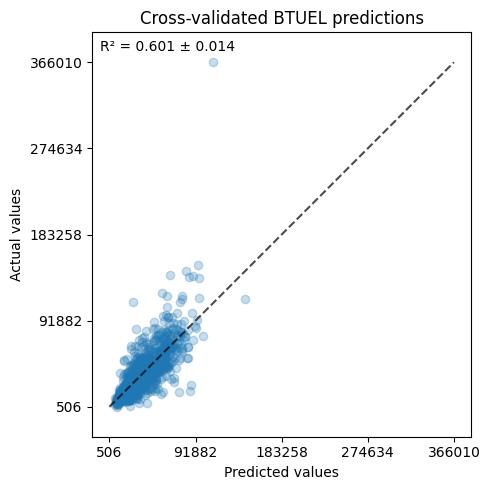

In [34]:
def evaluate_regressor(target_var, regressor):
    target = targets[target_var]
    pipeline = make_pipeline(preprocessor, regressor)

    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_results = cross_validate(
        pipeline,
        data,
        target,
        cv=cv,
        scoring=["r2", "neg_median_absolute_error"],
    )

    scores = pd.DataFrame(
        {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_median_absolute_error"]}
    )
    print(
        "Coefficient of determination (R²):\n"
        f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
    )
    print(
        "Mean Absolute Error (MAE):\n"
        f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
    )

    y_pred = cross_val_predict(
        pipeline,
        data,
        target,
        cv=cv,
    )

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        target,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.25},
        random_state=42,
    )
    ax.set_title(f"Cross-validated {target_var} predictions")
    ax.text(
        0.02,
        0.98,
        f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
    plt.tight_layout()
    plt.show()

target_var = "BTUEL"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)


Coefficient of determination (R²):
0.779 ± 0.012
Mean Absolute Error (MAE):
2522.074 ± 266.647


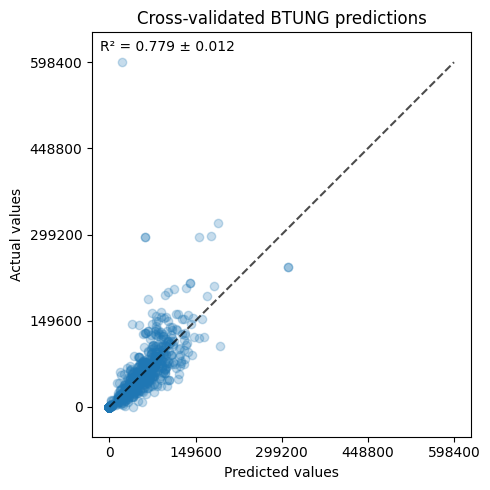

In [35]:
target_var = "BTUNG"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)


Coefficient of determination (R²):
0.782 ± 0.013
Mean Absolute Error (MAE):
0.091 ± 0.011


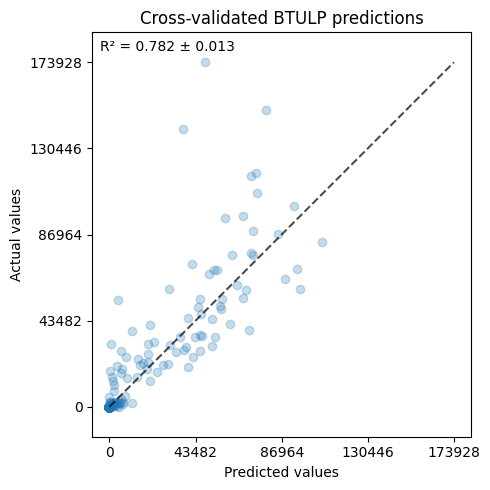

In [36]:
target_var = "BTULP"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)


Coefficient of determination (R²):
0.837 ± 0.019
Mean Absolute Error (MAE):
0.001 ± 0.001


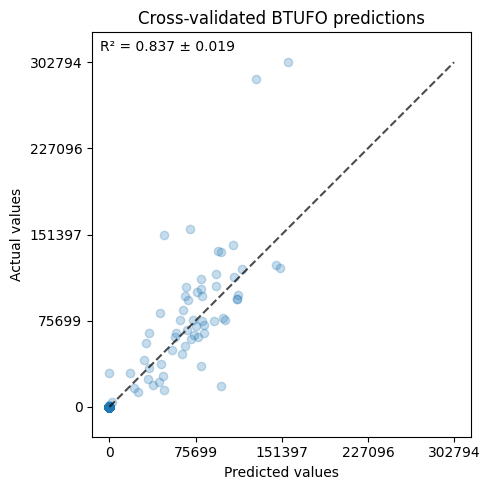

In [37]:
target_var = "BTUFO"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)


Coefficient of determination (R²):
0.604 ± 0.024
Mean Absolute Error (MAE):
0.008 ± 0.003


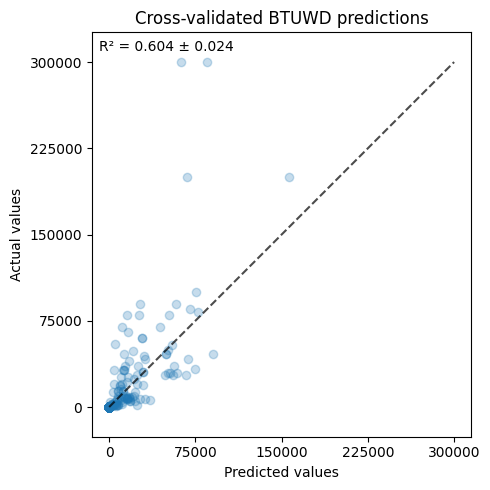

In [38]:
target_var = "BTUWD"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)


## Create and Export Final Model

In [39]:
target = targets

regressor = MultiOutputRegressor(
    lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)
)

model = make_pipeline(preprocessor, regressor)
model.fit(data, target)

filename = "../model.joblib"
joblib.dump(model, filename)


['../model.joblib']